## Setup the MNIST dataset

In [13]:
# Imports
import functools as ft
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

import torch
from torch import nn, optim

import pandas
from sklearn import decomposition
from sklearn.datasets import fetch_openml

In [2]:
# MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.T / 255
y = np.array([int(label) for label in y])

In [7]:
# Run PCA
row_mean = X.mean(axis=1)
X_zero = X - row_mean.reshape([-1, 1])

pca = decomposition.PCA()
pca.fit(X_zero.T)
components = pca.components_

# PCA dimensionality reduction
n_dim = 5
comp = components[:n_dim, :]
proj = comp @ X_zero
print(proj.shape)

# We will only use 0 and 1 for binary classification
input_x = proj[:, np.logical_or(y == 0, y == 1)]
label_y = y[np.logical_or(y == 0, y == 1)]

x = torch.from_numpy(input_x.T.astype(np.float32))

(5, 70000)


In [8]:
def input_dataset(n_dim):
    comp = components[:n_dim, :]
    proj = comp @ X_zero
    input_x = proj[:, np.logical_or(y == 0, y == 1)]
    label_y = y[np.logical_or(y == 0, y == 1)]
    
    return (input_x, label_y)

## Measure different "labeling"

In [10]:
n_mid = 20
model = nn.Sequential(
    nn.Linear(n_dim, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, 1),
    nn.Sigmoid())

In [6]:
n_mid = 10
model = nn.Sequential(
    nn.Linear(n_dim, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, 1),
    nn.Sigmoid())

In [290]:
# init all weights to 0
def weight_zero(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        m.weight.data.fill_(0)
        m.bias.data.fill_(0)

# apply uniform init to weights
def weight_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(-1e2, 1e2)
        m.bias.data.fill_(0)

# apply weights sampled from a Gaussian distribution
def weight_gaussian(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1.0)
        m.bias.data.fill_(0)
  

In [8]:
# Simple testing 
model.apply(weight_uniform)
with torch.no_grad():
    output = (model(x) < 0.5).numpy()

output

array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [16]:
# Subsample n input
n_input = 10
index = np.random.randint(input_x.shape[1], size=n_input)
x_sub = input_x[:, index]
x_sub = torch.from_numpy(x_sub.T.astype(np.float32))
print(label_y[index]) 

[0 1 1 0 0 1 0 1 1 1]


In [17]:
n_run = int(1e4)
result = np.zeros(2 ** n_input)
for idx in range(n_run):
    model.apply(weight_uniform)
    with torch.no_grad():
        output = (model(x_sub) < 0.5).numpy().astype(int).reshape([-1])
        encode = ft.reduce(lambda a,b:str(a)+str(b), output)
        index  = int(encode, 2)

        if result[index] == 0:
            result[index] = 1

sum(result)

422.0

In [4]:
# Define a helper function for the counting routine
def vc_dimension(model, weight_init, input_x, n_input, n_run=10):
    label_count = 0    
    for run in range(n_run):
        # random sample some input
        index = np.random.randint(input_x.shape[1], size=n_input)    
        x_sub = torch.from_numpy(input_x[:, index].T.astype(np.float32))
        
        # sample weights and count all possible labeling
        result = np.zeros(2 ** n_input)
        n_sample = int((2 ** n_input) * 25)
        for sample in range(n_sample):
            model.apply(weight_init)
            with torch.no_grad():
                output = (model(x_sub) < 0.5).numpy().astype(int).reshape([-1])                
                encode = ft.reduce(lambda a, b: str(a) + str(b), output)                
                index  = int(encode, 2)
                
                if result[index] == 0:
                    result[index] = 1
                    
        label_count += sum(result)
        
    return label_count / n_run

In [95]:
vc_dimension(model, weight_uniform, input_x, n_input=8)

252.4

## VC Dimension Curve

In [106]:
# Input dimension
n_dim = 200
(input_x, label_y) = input_dataset(n_dim=n_dim)

In [107]:
# Define some model
n_mid = 10
model = nn.Sequential(
    nn.Linear(n_dim, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, 1),
    nn.Sigmoid())

In [108]:
vc_dimension(model, weight_uniform, input_x, n_input=12)

3717.5

In [117]:
# Compute VC - Data Dim
def compute_curve(input_x, model, weight_init):
    n_label = []
    for n_input in range(2, 13):
        count = vc_dimension(model, weight_init, input_x, n_input=n_input)
        n_label.append(count)
        
    return n_label

In [136]:
# Compute for a simple model
n_dim = 2
(input_x, label_y) = input_dataset(n_dim=n_dim)

n_mid = 10
model = nn.Sequential(
    nn.Linear(n_dim, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, 1),
    nn.Sigmoid())

count_tiny = compute_curve(input_x, model, weight_uniform)
print(count_tiny)

[3.8, 6.7, 11.1, 18.6, 29.7, 42.5, 59.1, 93.9, 132.7, 195.7, 274.9]


In [118]:
# Compute for a simple model
n_dim = 4
(input_x, label_y) = input_dataset(n_dim=n_dim)

n_mid = 10
model = nn.Sequential(
    nn.Linear(n_dim, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, 1),
    nn.Sigmoid())

count_simple = compute_curve(input_x, model, weight_uniform)
print(count_simple)

[4.0, 7.9, 14.2, 27.9, 51.4, 84.8, 165.2, 250.5, 443.8, 764.8, 1377.8]


In [122]:
# Increase input dimension
n_dim = 16
(input_x, label_y) = input_dataset(n_dim=n_dim)

n_mid = 10
model = nn.Sequential(
    nn.Linear(n_dim, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, 1),
    nn.Sigmoid())

count_mid = compute_curve(input_x, model, weight_uniform)
print(count_mid)

[4.0, 7.9, 15.8, 31.2, 62.0, 119.9, 233.3, 453.2, 851.6, 1571.7, 2809.2]


In [124]:
# Increase input dimension
n_dim = 250
(input_x, label_y) = input_dataset(n_dim=n_dim)

n_mid = 10
model = nn.Sequential(
    nn.Linear(n_dim, n_mid),
    nn.ReLU(),
    nn.Linear(n_mid, 1),
    nn.Sigmoid())

count_large = compute_curve(input_x, model, weight_uniform)
print(count_large)

[4.0, 8.0, 16.0, 32.0, 63.8, 126.6, 254.0, 496.0, 988.7, 1942.2, 3794.0]


### Effect of Input Dimension

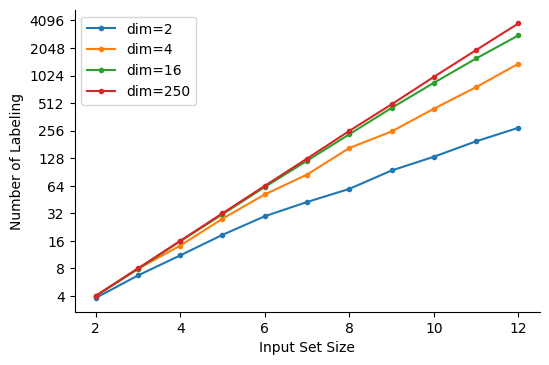

In [235]:
def log2_plot(data, label, x_axis=range(2, 13)):
    plt.plot(x_axis, data, '.-', label=label)

# Figure format
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

x_axis = range(2, 13)
    
log2_plot(count_tiny, 'dim=2')
log2_plot(count_simple, 'dim=4')
log2_plot(count_mid, 'dim=16')
log2_plot(count_large, 'dim=250')

plt.yscale('log')
plt.minorticks_off()
plt.xlabel('Input Set Size')
plt.ylabel('Number of Labeling')

ax.set_yticks([2 ** n for n in x_axis])
ax.set_yticklabels([2 ** n for n in x_axis])
ax.legend()
plt.show()

### Effect of network complexity

In [199]:
# Input dimension
n_dim = 4
(input_x, label_y) = input_dataset(n_dim=n_dim)

In [200]:
# Simple linear regression
model = nn.Sequential(
    nn.Linear(n_dim, 1),
    nn.Sigmoid())

In [201]:
count_linear = compute_curve(input_x, model, weight_uniform)
print(count_linear)

[4.0, 7.7, 13.3, 23.3, 36.2, 55.0, 88.9, 125.7, 182.8, 261.1, 341.1]


In [202]:
# Two layer
model = nn.Sequential(
    nn.Linear(n_dim, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid())

count_twolr = compute_curve(input_x, model, weight_uniform)
print(count_twolr)

[4.0, 7.6, 14.2, 26.9, 51.7, 88.8, 157.4, 283.7, 503.5, 807.3, 1384.4]


In [203]:
# Three layer
model = nn.Sequential(
    nn.Linear(n_dim, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
    nn.Sigmoid())

count_thrlr = compute_curve(input_x, model, weight_uniform)
print(count_thrlr)

[4.0, 8.0, 15.4, 28.3, 50.1, 91.0, 176.6, 290.7, 572.7, 909.7, 1499.5]


In [208]:
# Many layer
model = nn.Sequential(
    nn.Linear(n_dim, 25),
    nn.ReLU(),
    nn.Linear(25, 25),
    nn.ReLU(),
    nn.Linear(25, 25),
    nn.ReLU(),
    nn.Linear(25, 25),
    nn.ReLU(),
    nn.Linear(25, 25),
    nn.ReLU(),
    nn.Linear(25, 1),
    nn.Sigmoid())

count_many = compute_curve(input_x, model, weight_uniform)
print(count_many)

[3.9, 7.9, 15.3, 28.5, 52.8, 99.5, 182.0, 317.2, 549.0, 1012.5, 1848.7]


In [209]:
# Deep network
modules = []

modules.append(nn.Linear(n_dim, 25))
modules.append(nn.ReLU())
for n_iter in range(10):
    modules.append(nn.Linear(25, 25))
    modules.append(nn.ReLU())

modules.append(nn.Linear(25, 1))
modules.append(nn.Sigmoid())

model = nn.Sequential(*modules)

count_deep = compute_curve(input_x, model, weight_uniform)
print(count_deep)

[3.9, 8.0, 14.9, 28.1, 52.1, 97.4, 188.7, 337.5, 668.2, 1173.4, 2199.0]


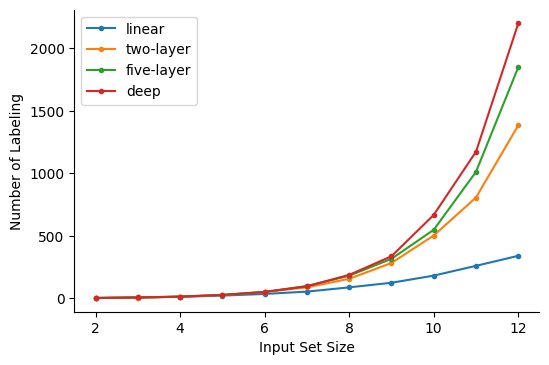

In [308]:
# Figure format
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

x_axis = range(2, 13)
    
log2_plot(count_linear, 'linear')
log2_plot(count_twolr, 'two-layer')
log2_plot(count_many, 'five-layer')
log2_plot(count_deep, 'deep')

plt.xlabel('Input Set Size')
plt.ylabel('Number of Labeling')

# plt.yscale('log')
# plt.minorticks_off()
# ax.set_yticks([2 ** n for n in x_axis])
# ax.set_yticklabels([2 ** n for n in x_axis])

ax.legend()
plt.show()

### Network Depth vs. Width

In [250]:
# Input dimension
n_dim = 4
(input_x, label_y) = input_dataset(n_dim=n_dim)

In [257]:
n_count = [] 
for n_mid in range(25, 256, 25):
    
    model = nn.Sequential(
        nn.Linear(n_dim, n_mid),
        nn.ReLU(),
        nn.Linear(n_mid, 1),
        nn.Sigmoid())
    
    n_count.append(vc_dimension(model, weight_uniform, input_x, n_input=12))
    
print(n_count)

[1365.7, 1265.5, 1362.8, 1356.4, 1435.8, 1327.6, 1314.0, 1428.3, 1256.8, 1318.7]


In [268]:
n_seq = []
for n_layer in range(10):
    modules = []
    
    modules.append(nn.Linear(n_dim, 25))
    modules.append(nn.ReLU())
    for n_iter in range(n_layer):
        modules.append(nn.Linear(25, 25))
        modules.append(nn.ReLU())
        
    modules.append(nn.Linear(25, 1))
    modules.append(nn.Sigmoid())
    
    model = nn.Sequential(*modules)
    n_seq.append(vc_dimension(model, weight_uniform, input_x, n_input=12))
    
print(n_seq)

[1342.8, 1614.8, 1626.3, 1892.4, 1900.7, 2027.0, 1927.6, 2034.8, 2095.6, 2040.7]


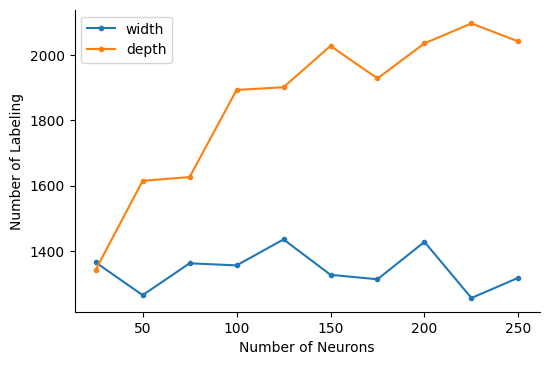

In [271]:
# Figure format
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.plot(range(25, 256, 25), n_count, '.-', label='width')
plt.plot(range(25, 256, 25), n_seq, '.-', label='depth')

plt.xlabel('Number of Neurons')
plt.ylabel('Number of Labeling')

ax.legend()
plt.show()

## Regularization

### Dropout

In [291]:
# Input dimension
n_dim = 4
(input_x, label_y) = input_dataset(n_dim=n_dim)

In [298]:
modules = []

modules.append(nn.Linear(n_dim, 25))
modules.append(nn.ReLU())
for n_iter in range(6):
    modules.append(nn.Linear(25, 25))
    modules.append(nn.ReLU())
    if n_iter % 2 == 0:
        modules.append(nn.Dropout(p=0.50))

modules.append(nn.Linear(25, 1))
modules.append(nn.Sigmoid())

model = nn.Sequential(*modules)
model.train()

count_dropout = compute_curve(input_x, model, weight_uniform)
print(count_dropout)

[4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1023.9, 2048.0, 4095.7]


In [299]:
modules = []

modules.append(nn.Linear(n_dim, 25))
modules.append(nn.ReLU())
for n_iter in range(6):
    modules.append(nn.Linear(25, 25))
    modules.append(nn.ReLU())

modules.append(nn.Linear(25, 1))
modules.append(nn.Sigmoid())

model = nn.Sequential(*modules)

count = compute_curve(input_x, model, weight_uniform)
print(count)

[4.0, 8.0, 15.0, 28.4, 55.4, 93.1, 191.3, 328.4, 602.0, 1114.0, 2009.7]


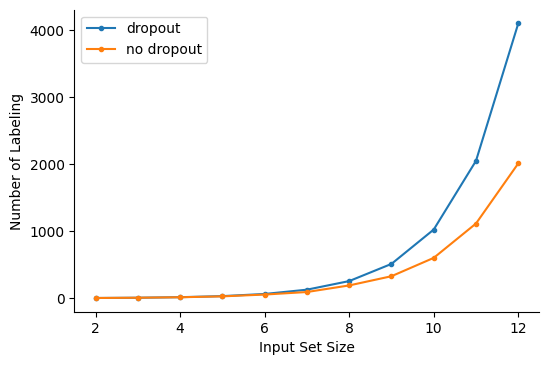

In [315]:
# Figure format
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.plot(range(2, 13), count_dropout, '.-', label='dropout')
plt.plot(range(2, 13), count, '.-', label='no dropout')

plt.xlabel('Input Set Size')
plt.ylabel('Number of Labeling')

# plt.yscale('log')
# plt.minorticks_off()
# ax.set_yticks([2 ** n for n in x_axis])
# ax.set_yticklabels([2 ** n for n in x_axis])

ax.legend()
plt.show()

### L1 and L2 norm

In [9]:
# Input dimension
n_dim = 4
(input_x, label_y) = input_dataset(n_dim=n_dim)

In [341]:
# Different weight init
def weight_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(-1, 1)
        m.bias.data.fill_(0)
        
def weight_gaussian(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.1)
        m.bias.data.fill_(0)
        
def weight_xavier_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))        
        m.bias.data.fill_(0)
        
def weight_xavier_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        m.bias.data.fill_(0)

In [10]:
def create_network(n_dim, n_mid=25, n_layer=10):
    modules = []
    
    modules.append(nn.Linear(n_dim, n_mid))
    modules.append(nn.ReLU())
    for n_iter in range(n_layer):
        modules.append(nn.Linear(n_mid, n_mid))
        modules.append(nn.ReLU())

    modules.append(nn.Linear(n_mid, 1))
    modules.append(nn.Sigmoid())

    return nn.Sequential(*modules)

In [321]:
model = create_network(n_dim=4)

count_uniform = compute_curve(input_x, model, weight_uniform)
print(count_uniform)

[4.0, 7.8, 15.3, 28.0, 52.8, 98.9, 182.3, 373.3, 614.7, 1111.8, 2019.0]


In [326]:
model = create_network(n_dim=4)

count_normal = compute_curve(input_x, model, weight_gaussian)
print(count_normal)

[4.0, 8.0, 14.5, 27.3, 51.5, 102.6, 166.8, 311.0, 590.5, 1114.7, 2124.1]


In [343]:
model = create_network(n_dim=4)

count_xavier_uniform = compute_curve(input_x, model, weight_xavier_uniform)
print(count_xavier_uniform)

[4.0, 7.8, 15.2, 27.8, 52.2, 104.7, 192.1, 347.1, 641.6, 1071.2, 2110.4]


In [344]:
model = create_network(n_dim=4)

count_xavier_normal = compute_curve(input_x, model, weight_xavier_normal)
print(count_xavier_normal)

[3.9, 7.5, 14.7, 29.8, 51.7, 100.0, 184.6, 349.4, 633.8, 1121.8, 2175.7]


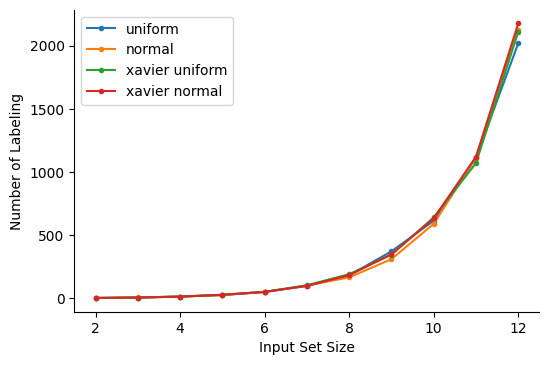

In [347]:
# Figure format
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.plot(range(2, 13), count_uniform, '.-', label='uniform')
plt.plot(range(2, 13), count_normal, '.-', label='normal')
plt.plot(range(2, 13), count_xavier_uniform, '.-', label='xavier uniform')
plt.plot(range(2, 13), count_xavier_normal, '.-', label='xavier normal')

plt.xlabel('Input Set Size')
plt.ylabel('Number of Labeling')

# plt.yscale('log')
# plt.minorticks_off()
# ax.set_yticks([2 ** n for n in x_axis])
# ax.set_yticklabels([2 ** n for n in x_axis])

ax.legend()
plt.show()

### Gaussian S.D.

In [16]:
model = create_network(4, n_mid=25, n_layer=10)
sd_seq = [-3, -2, -1.6, -1.4, -1.3, -1.2, -1.1, -1, 0, 1, 2]

count = []
for idx in range(len(sd_seq)):    
    def weight_gaussian(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('Linear') != -1:
            m.weight.data.normal_(0.0, 10 ** sd_seq[idx])
            m.bias.data.fill_(0)
            
    count.append(vc_dimension(model, weight_gaussian, input_x, n_input=12))

print(count)

[1.0, 1.0, 1.0, 1.0, 1.0, 28.5, 1114.0, 1948.2, 2064.9, 2203.4]


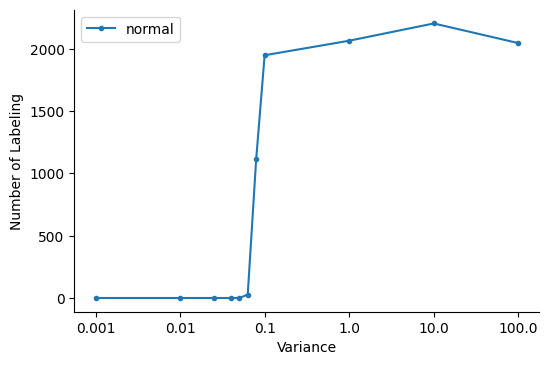

In [28]:
# Figure format
ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.plot(sd_seq, count, '.-', label='normal')

plt.xlabel('Variance')
plt.ylabel('Number of Labeling')

ax.set_xticks(np.arange(-3, 2.1, 1.0))
ax.set_xticklabels([10 ** n for n in np.arange(-3, 2.1, 1.0)])

ax.legend()
plt.show()